# Evalutation of Classifiers on full dataset (05/17/2017)

The following are details of my experiments using the Random Forest and Logistic Regression learning methods.

In [1]:
import time
import numpy as np
random_state = 1
np.random.seed(random_state)
import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.cm as cm
import time
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
from utils import load_data_h5, combine_positive_negative_data, generate_report
from keras_utils import precision, recall
import keras.backend as K
from keras import losses
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras_utils import generate_report_keras
from keras.layers import Input, Dense, BatchNormalization
from keras.models import Model
from keras import objectives
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.advanced_activations import LeakyReLU, PReLU
from sklearn.preprocessing import normalize



norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = cm.Spectral
m = cm.ScalarMappable(norm=norm, cmap=cmap)



Using TensorFlow backend.


## Load the data and create the training/testing splits

In [2]:
t0 = time.clock()
X_p, y_p = load_data_h5("data/ml_pro_features_labels.h5", mode=1)
X_n, y_n = load_data_h5("data/ml_pro_features_labels.h5", mode=0)

print("Data loaded in ", (time.clock() - t0), " seconds.")

X = combine_positive_negative_data(X_n, X_p)
y = combine_positive_negative_data(y_n, y_p)

t1 = time.clock()
# specify y to stratfiy in order to preserve proportion of positives to negatives
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
t2 = time.clock()


print ("Train-Test split: ",X_train.shape[0], "(train)","\t",X_test.shape[0], "(test)")
print("Train-Test split completed in ", (t2-t1), " seconds.")

Data loaded in  1.4196109999999997  seconds.
Train-Test split:  159801 (train) 	 39951 (test)
Train-Test split completed in  0.080673  seconds.


/home/carl/anaconda3/envs/protein_binding/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression trained on full features in  32.165350999999994  seconds.


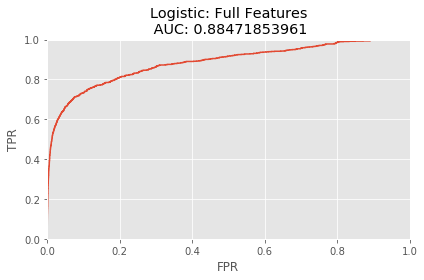

In [3]:
logistic = LogisticRegression(random_state=random_state)
t5 = time.clock()
logistic.fit(X_train, y_train)
print ("Logistic Regression trained on full features in ", (time.clock() - t5), " seconds.")
logistic_preds = logistic.predict(X_test)
generate_report("Logistic: Full Features", logistic, X_test, y_test)

Optimal max tree depth:  18


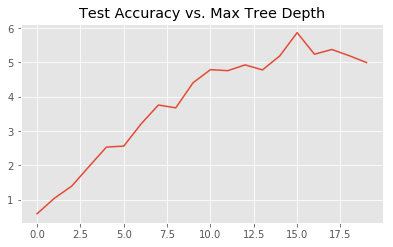

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

optimal_depth = 1
best_acc_score = 0
accuracy_scores = []
skf = StratifiedKFold(n_splits = 20, random_state=random_state)
i = 1
for train_index, test_index in skf.split(X_train,y_train.flatten()):
    X_train_strat,X_test_strat = X_train[train_index], X_train[test_index]
    y_train_strat, y_test_strat = y_train[train_index], y_train[test_index]
    
    rforest = RandomForestClassifier(max_depth=i,random_state=random_state)
    t1 = time.clock()
    rforest.fit(X_train_strat, y_train_strat.flatten())
    preds_i = rforest.predict(X_test_strat)
    acc_i = accuracy_score(y_test_strat,preds_i)
    if (acc_i > best_acc_score):
        best_acc_score = acc_i
        optimal_depth = i
    accuracy_scores.append(acc_i)
    i+=1
print ("Optimal max tree depth: ",optimal_depth)
rforest = RandomForestClassifier(max_depth = optimal_depth,random_state=random_state)
rforest.fit(X_train,y_train.flatten())
generate_report("Random Forest: Full Features", rforest, X_test, y_test)
plt.clf()
plt.title("Test Accuracy vs. Max Tree Depth")
plt.plot(list(range(i-1)),training_times)
plt.show()

# Dimensionality Reduction

In [5]:
X_p, y_p = load_data_h5("data/ml_pro_features_labels.h5", mode=1)
X_n, y_n = load_data_h5("data/ml_pro_features_labels.h5", mode=0)


X = combine_positive_negative_data(X_n, X_p)
y = combine_positive_negative_data(y_n, y_p)

### Linear Dimensionality Reduction (PCA)

In [6]:
X_norm = normalize(X)

pca = PCA(n_components=6)

reduced_x_ = pca.fit_transform(X_norm)

reconstructed_x = pca.inverse_transform(reduced_x_)

error = mean_squared_error(X_norm,reconstructed_x)
print("PCA Reconstruction Error:" ,error)

PCA Reconstruction Error: 5.46383838177e-07


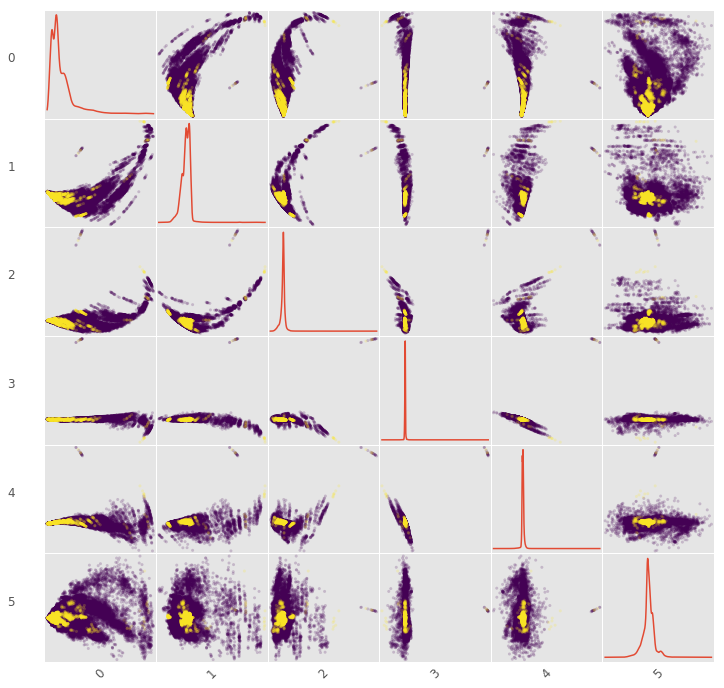

In [7]:
reduced_x_ = pd.DataFrame(reduced_x_)


y_labels = pd.DataFrame(y)

plt.clf()
sm = pd.plotting.scatter_matrix(reduced_x_,alpha=0.2, c = y_labels[0],figsize=(12,12),diagonal='kde')

[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

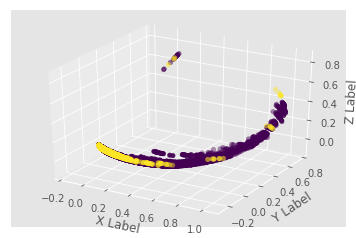

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = reduced_x_.as_matrix()[:,0]
ys = reduced_x_.as_matrix()[:,1]
zs = reduced_x_.as_matrix()[:,2]
ax.scatter(xs, ys, zs, c=y_labels[0])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

### Non-linear Dimensionality Reduction
Due to limitations in the scikit-learn dimensionality reduction techniques, an autoencoder deep network is trained to perform the non-linear dimensionality reduction.

### Autoencoder

In [9]:
time_stamp = time.clock()


X_,y_ = load_data_h5("data/ml_pro_features_labels.h5")
X_ = normalize(X_)

num_epochs = 1000
encoding_dim = 3
learning_rate = 1e-3

input_data = Input(shape=(188,))
alpha = 'glorot_uniform'

encoded = Dense(100)(input_data)
encoded = PReLU(alpha_initializer=alpha)(encoded)
encoded = Dense(50)(encoded)
encoded = PReLU(alpha_initializer=alpha)(encoded)
encoded = Dense(25)(encoded)
encoded = PReLU(alpha_initializer=alpha)(encoded)
encoded = Dense(encoding_dim)(encoded)
encoded = PReLU(alpha_initializer=alpha)(encoded)

decoded = Dense(25)(encoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)
decoded = Dense(50)(decoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)
decoded = Dense(100)(decoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)
decoded = Dense(188)(decoded)
decoded = PReLU(alpha_initializer=alpha)(decoded)

autoencoder = Model(input_data, decoded)
print (autoencoder.summary())

encoder = Model(input_data, encoded)
print (encoder.summary())

encoded_input = Input(shape=(encoding_dim,))

decoder = Model(encoded_input,autoencoder.layers[-1](autoencoder.layers[-2](autoencoder.layers[-3](autoencoder.layers[-4](
    autoencoder.layers[-5](autoencoder.layers[-6](autoencoder.layers[-7](autoencoder.layers[-8](encoded_input)))))))))

print (decoder.summary())

autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate),loss=objectives.mean_squared_error)


autoencoder.fit(X_,X_,epochs=num_epochs,batch_size=64,shuffle=True,validation_split=0.2,callbacks=[EarlyStopping(min_delta=1e-7),ModelCheckpoint("best_autoenc_"+str(time_stamp)+"_model.h5")])

enc_red_x = encoder.predict(X_)
enc_recon_x = decoder.predict(enc_red_x)
enc_error = mean_squared_error(X_,enc_recon_x)
print("Autoencoder Reconstruction Error: ",enc_error)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 188)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               18900     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 100)               100       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 50)                50        
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 25)                25        
__________

#### Visualize Positives

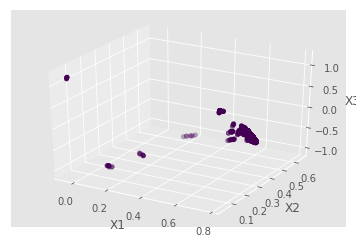

In [10]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pos_idxs = y_[:] > 0
pos_idxs = pos_idxs.flatten()

xs = enc_red_x[pos_idxs][:,0] 
ys = enc_red_x[pos_idxs][:,1]
zs = enc_red_x[pos_idxs][:,2]
ax.scatter(xs, ys, zs, c=y_[pos_idxs])

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.savefig(str(time_stamp)+"_positives_final_nonlinear_dim_reduction.png")
plt.show()

#### Visualize Negatives

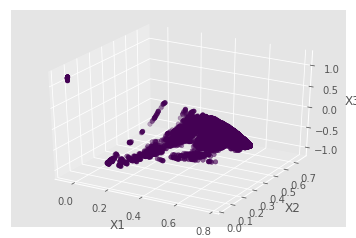

In [11]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


neg_idxs = y_[:] < 1
neg_idxs = neg_idxs.flatten()

xs = enc_red_x[neg_idxs][:,0] 
ys = enc_red_x[neg_idxs][:,1]
zs = enc_red_x[neg_idxs][:,2]
ax.scatter(xs, ys, zs, c=y_[neg_idxs])


ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.savefig(str(time_stamp)+"_negatives_final_nonlinear_dim_reduction.png")
plt.show()

#### Complete Visualization

In [ ]:
plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = enc_red_x[:,0] 
ys = enc_red_x[:,1]
zs = enc_red_x[:,2]
ax.scatter(xs, ys, zs, c=y_)


ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.savefig(str(time_stamp)+"combined_final_nonlinear_dim_reduction.png")
plt.show()